In [1]:
# importing the libraries
# basic stuff
import pandas as pd
import numpy as np
import math
import re
import nltk #swiss knife army for nlp
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
from tqdm import tqdm
from pymystem3 import Mystem

# nltk stemmers
stemmerRu = SnowballStemmer("russian") 
stemmerEn = PorterStemmer()
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering



In [3]:
# preprocessing function
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
    #lem_words=[Mystem().lemmatize(w) for w in filtered_words]
    #stem_words=[stemmerRu.stem(w) for w in filtered_words]
    return " ".join(filtered_words)




In [2]:
#%time df.to_csv('/Users/apple/BDML/data/trained_clean.csv')
df = pd.read_csv(r'/Users/apple/BDML/data/trained_clean.csv')
df = df.drop(['Unnamed: 0', 'text'], axis = 1)
df.head()

,doc_id,clean
0,0,открыта вакансия составитель заявок рассмотрим...
1,1,неловкое чувство когдα боишься нαписαть челове...
2,2,нахуй нужна твоё отсутствие жизни делает люди ...
3,3,хотите уходите привыкать брат дома бесuт скуча...
4,4,представляете насколько весы нуждаются тепле л...


In [3]:
import artm


# creating the function for transformation to vowpal_wabbit format

def df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='clean'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write('|{0} '.format( namespace))
            else:
                f.write('{0} | '.format(row[target]))
            last_feature = row.index.values[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write('{0}:{1}'.format(idx.replace(' ', ' ').replace(':', ' '), val))
                    else:
                        continue
                else:
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')



In [4]:
# changing the type of data created
vw = df_to_vw_regression(df, filepath='data_df.txt', target='doc_id')

73987it [00:11, 6661.42it/s]


In [5]:

# batching data for applying it to our model
batch_vectorizer = artm.BatchVectorizer(data_path='data_df.txt',
                                        data_format='vowpal_wabbit',
                                        collection_name='vw',
                                        target_folder='batches2')

#batch_vectorizer = artm.BatchVectorizer(data_path='batches2', data_format='batches')


In [6]:
  # setting up dictionary
dictionary = batch_vectorizer.dictionary

In [7]:
number_of_topics = 60
topic_names = ['topic_{}'.format(i) for i in range(number_of_topics)]

# inial objects creation
model_artm = artm.ARTM(topic_names=topic_names,
                       cache_theta=True,
                       dictionary=dictionary, 
                       seed = 123,
                       show_progress_bars = True)

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary = dictionary))
#model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
#model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
#model_artm.scores.add(artm.TopTokensScore(name='Top_words', num_tokens=20, class_id='text'))
model_artm.scores.add(artm.TopTokensScore(name='top_words',num_tokens = 10))

# additional regulizers
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+4))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseTheta', tau=- 0.05))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau= 0.3, topic_names= topic_names))#[35:]))

#setting up the number of tokens
model_artm.num_document_passes = 10

#initializing the model we've set up
model_artm.initialize(dictionary=dictionary)

In [8]:
# fitting the model
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=16)


CPU times: user 1h 30min 26s, sys: 2min 17s, total: 1h 32min 44s
Wall time: 18min 16s


In [9]:
# phi and theta
artm_phi = model_artm.get_phi()
artm_theta = model_artm.get_theta()
## top_tokens
top_tokens = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print ('\n',topic_name)
    for (token, weight) in zip(top_tokens.last_tokens[topic_name][:number_of_topics],top_tokens.last_weights[topic_name][:number_of_topics]):
        print (token, '-', weight)


 topic_0
цена - 0.012518704868853092
наличии - 0.011896690353751183
руб - 0.009832998737692833
цвет - 0.006364929955452681
рублей - 0.0056762173771858215
цвета - 0.005186707247048616
заказ - 0.004840677138417959
размер - 0.004179018549621105
размеры - 0.00391771225258708
материал - 0.0035426041577011347

 topic_1
срок - 0.009537801146507263
лет - 0.008417372591793537
доставка - 0.006420993246138096
года - 0.005376922432333231
права - 0.005079893860965967
дней - 0.0048171766102313995
размере - 0.0045396145433187485
случае - 0.004088988993316889
суд - 0.003982226364314556
рублей - 0.003683647606521845

 topic_2
день - 0.013244856148958206
сегодня - 0.011520991101861
стоит - 0.005784454755485058
дня - 0.004500417970120907
постарайтесь - 0.0044370414689183235
отношения - 0.004127827472984791
работа - 0.0035052539315074682
возможно - 0.003435312770307064
дела - 0.003052842104807496
здоровье - 0.003041259478777647

 topic_3
делать - 0.007886339910328388
вопрос - 0.006343554705381393
лет - 0

Text(0, 0.5, 'perplexity score')

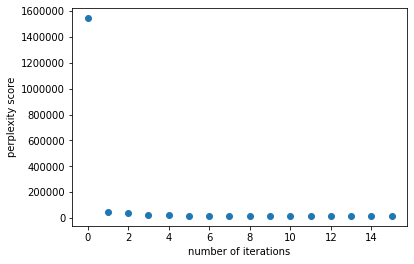

In [10]:
perplexityScore = list(model_artm.score_tracker['PerplexityScore'].value)

%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

# visualizing perplexity
plt.scatter(range(len(perplexityScore)), perplexityScore)
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

In [ ]:
lables = dict()
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

for topic_name in model_artm.topic_names:
    
    lables[topic_name] = ' '.join(word for word in top_tokens.last_tokens[topic_name][0:6])
    lables[topic_name] = ''.join(Mystem().lemmatize(lables[topic_name]))
    lables[topic_name] = ' '.join(unique_list(lables[topic_name].split()))
    
    print(lables[topic_name])
    #lables[topic_name] = Mystem.lemmatize(text = lables[topic_name])
    artm_theta.rename({topic_name:lables[topic_name]}, inplace = True)
lables


цена наличие руб цвет рубль
срок год доставка право день
день сегодня стоять постараться отношение
делать вопрос год поэтому часто ставить
игра матч футбол команда мир
гороскоп сегодня рождаться июнь август июль
радоваться бог господь христос
область год россия район город дтп
хотеть лайк нахуй любить блять репост
ребенок жизнь
деньги день человек жизнь год
год век дизайн место дом музей
озеро город мир метр остров парк
волос sex big tits anal
что это как так я ты
від ціна або але характеристика буде
iphone apple видео новый android google
человек жизнь ремарк
альбом amp love рок группа
руб работа тело требоваться дом квартира
человек бизнес жизнь должный
год мама сказать говорить дверь домой
день нога мышца упражнение тело
почему сегодня день делать знать говорить
минута масло вода затем добавлять
ученый год иметь собака длина
хотеть любовь друг жизнь рядом
человек лишь смерть мир
несколько становиться дома снова смерть
человек имя энергия деньги жизнь сила
год сша нью
человек любить 

In [25]:
text = "чтo этo кaк тaк мeня"
lemmas = Mystem().lemmatize(text)
print(''.join(lemmas))

что это как так я



In [31]:
theta_transposed = artm_theta.transpose()

#odd_themes = ['чтo этo кaк тaк мeня','человека люди людей именно часто',
#              'люди жизнь человека сегодня жить','почему сегодня день делать знаю',
#              'лет мама говорит дверь сказал','делать женщины вопрос женщина мужчины'
#              
#             ]
#theta_transposed.drop(columns = odd_themes)


#theta_transposed.to_csv('theta_transposed.csv')
#theta_transposed = pd.read_csv(r'theta_transposed.csv')

df['theme'] = theta_transposed.idxmax(axis=1)
df.head()

,doc_id,clean,theme,_id
0,0,открыт ваканс составител заявок рассмотр студе...,работ треб тел график бар,-171585368
1,1,неловк чувств когдα бо нαписαт человек думαеш ...,тво глаз рук ноч зна,-171404269
2,2,нах нужн тво отсутств жизн дела люд станов бли...,хоч любл мам лет девушк,-171378742
3,3,хот уход привыка брат дом бесут скуча жал полу...,хоч любл мам лет девушк,-171324398
4,4,представля наскольк вес нужда тепл ласк нежнос...,жизн люб люд сам лучш,-171288949


In [32]:
group_user = pd.read_csv(r'/Users/apple/BDML/data/group_user.csv')
lables = pd.read_csv(r'/Users/apple/BDML/data/train_ids.csv')
df = df.merge(lables, on = 'doc_id')
df.head()

,doc_id,clean,theme,_id_x,_id_y
0,0,открыт ваканс составител заявок рассмотр студе...,работ треб тел график бар,-171585368,-171585368
1,1,неловк чувств когдα бо нαписαт человек думαеш ...,тво глаз рук ноч зна,-171404269,-171404269
2,2,нах нужн тво отсутств жизн дела люд станов бли...,хоч любл мам лет девушк,-171378742,-171378742
3,3,хот уход привыка брат дом бесут скуча жал полу...,хоч любл мам лет девушк,-171324398,-171324398
4,4,представля наскольк вес нужда тепл ласк нежнос...,жизн люб люд сам лучш,-171288949,-171288949


In [33]:
df.theme.unique()

array(['работ треб тел график бар', 'тво глаз рук ноч зна',
       'хоч любл мам лет девушк', 'жизн люб люд сам лучш',
       'любов люб сердц счаст друг', 'нов компан сайт iphon пользовател',
       'что эт как так теб', 'поч говор мужик дела смотр',
       'групп добр фот помог сдела',
       'год петербург александр художник город',
       'нов автомобил цен двигател машин',
       'водител полиц район автомобил летн', 'лайк мест репост друз анон',
       'част мест вод поверхн длин', 'прод квартир дом цен состоян',
       'организм заболеван здоров веществ продукт',
       'цен руб размер нов отд', 'девушк секс парн хоч член',
       'цвет фотограф стил дизайн ярк', 'друг человек дума кажд люд',
       'говор сказа жен девушк мам', 'дет ребенк собак мам лет',
       'год сер нов сезон групп', 'игр нов игра игрок карт',
       'росс год област российск украин',
       'матч команд побед чемпионат футбол', 'сам мир город год сша',
       'дела жизн люд сдела успех', 'волос кож маск л

In [35]:
interests = group_user \
    .merge(df,left_on = 'group', right_on = '_id_x' ) \
    .drop(['clean', 'doc_id'], axis = 1) \
    .sort_values('user')
interests = interests.reset_index()

In [36]:

interests = interests.pivot_table(index = 'user', columns='theme') \
    .replace(np.nan, 0) 

    

In [37]:
interests

_id_x                                 \
theme     amp lov black man bmw бизнес ваш клиент работ компан   
user                                                             
138                         0.0                   0.000000e+00   
175                         0.0                   0.000000e+00   
176                         0.0                   0.000000e+00   
200                         0.0                   0.000000e+00   
252                         0.0                   0.000000e+00   
609                         0.0                   0.000000e+00   
713                         0.0                   0.000000e+00   
882                 -60736066.6                  -4.125395e+07   
936                         0.0                   0.000000e+00   
964                 -25153764.0                   0.000000e+00   
1112                        0.0                  -7.555074e+07   
1139                        0.0                   0.000000e+00   
1221                        0.0                  -3.045608e+07   
1301                        0.0                  -1.161229e+08   
1483                -25153764.0                  -3.738040e+07   
1683                        0.0                   0.000000e+00   
1701                        0.0                   0.000000e+00   
2023                        0.0                  -1.140007e+08   
2031                -88497493.0                  -4.423371e+07   
2076                        0.0                   0.000000e+00   
2124                        0.0                   0.000000e+00   
2158                        0.0                   0.000000e+00   
2214                        0.0                   0.000000e+00   
2340                -34424309.5                  -4.996154e+07   
2352                        0.0                   0.000000e+00   
2376                        0.0                   0.000000e+00   
2495                        0.0                   0.000000e+00   
2611                        0.0                   0.000000e+00   
2738                        0.0                   0.000000e+00   
2765                        0.0                   0.000000e+00   
...                         ...                            ...   
440144209                   0.0                   0.000000e+00   
440153261                   0.0                   0.000000e+00   
440184247                   0.0                   0.000000e+00   
440366514                   0.0                   0.000000e+00   
440496039                   0.0                   0.000000e+00   
440591364                   0.0                   0.000000e+00   
440928808                   0.0                   0.000000e+00   
440976066                   0.0                   0.000000e+00   
441102910                   0.0                   0.000000e+00   
441120732                   0.0                   0.000000e+00   
441217423                   0.0                   0.000000e+00   
441314164           -34305040.0                  -9.268663e+07   
441339414                   0.0                   0.000000e+00   
441461003                   0.0                  -1.462656e+08   
441566330                   0.0                   0.000000e+00   
441579113                   0.0                   0.000000e+00   
441764935                   0.0                   0.000000e+00   
441873957                   0.0                   0.000000e+00   
441933226                   0.0                   0.000000e+00   
442401256                   0.0                   0.000000e+00   
442574664                   0.0                   0.000000e+00   
442847876                   0.0                   0.000000e+00   
442881491                   0.0                   0.000000e+00   
442904635                   0.0                   0.000000e+00   
442971935                   0.0                   0.000000e+00   
443148104                   0.0                   0.000000e+00   
443202777                   0.0                   0.000000e+00   
